![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 06 - Convolutional Neural Network</center>
### <center> 2D convolution and Introduction to Pytorch</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/Main2D_Cnn.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/06_CNN/Cnn2D_ExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- Record figures during training:
from Cnn2D_ExampleAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel, LearningRateSweep

### Download CIFAR10 dataset:

In [6]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

### Compute mean and variance:

In [7]:
vMean = oTrainSet.data.mean(axis=(0,1,2)) / 255
vStd  = oTrainSet.data.std (axis=(0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


### Set datasets with normalization:

In [8]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, transform=oTransform)

lClasses  = oTrainSet.classes

### Plot some examples:

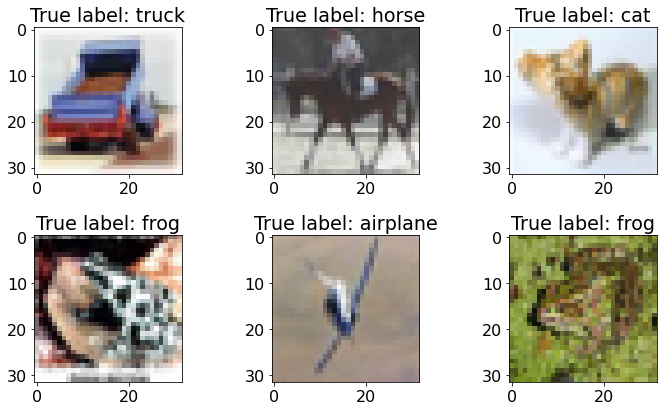

In [9]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    mX    = mX * vStd[:,None,None] + vMean[:,None,None] #-- unnormalizing, broadcast
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(np.transpose(mX.numpy(), [1, 2, 0]))
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Create data loaders:

In [10]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize)

### Define the model (2D CNN):

In [11]:
import torch.nn            as nn
import torch.nn.functional as F
import torchsummary

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, input):
        out = input.view(input.size(0),-1)
        return out

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Just for the summary (identity):
class InputLayer(nn.Sequential):
    pass
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        InputLayer(), #-- does nothing
        
        nn.Conv2d     (in_channels=3,   out_channels=30,  kernel_size=3, bias=False),
        nn.BatchNorm2d(num_features=30),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=30,  out_channels=60,  kernel_size=3, bias=False),
        nn.MaxPool2d  (kernel_size=2),
        nn.BatchNorm2d(num_features=60),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
                
        nn.Conv2d     (in_channels=60,  out_channels=120, kernel_size=3, bias=False),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d     (in_channels=120, out_channels=240, kernel_size=3, bias=False),
        nn.BatchNorm2d(240),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=240, out_channels=500, kernel_size=3, bias=False),
        nn.MaxPool2d  (2),
        nn.BatchNorm2d(500),
        nn.ReLU       (),
        
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(500, 10),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (C, H, W), device='cpu')
print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─InputLayer: 1-1                        [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 30, 30, 30]          810
├─BatchNorm2d: 1-3                       [-1, 30, 30, 30]          60
├─ReLU: 1-4                              [-1, 30, 30, 30]          --
├─Dropout2d: 1-5                         [-1, 30, 30, 30]          --
├─Conv2d: 1-6                            [-1, 60, 28, 28]          16,200
├─MaxPool2d: 1-7                         [-1, 60, 14, 14]          --
├─BatchNorm2d: 1-8                       [-1, 60, 14, 14]          120
├─ReLU: 1-9                              [-1, 60, 14, 14]          --
├─Dropout2d: 1-10                        [-1, 60, 14, 14]          --
├─Conv2d: 1-11                           [-1, 120, 12, 12]         64,800
├─BatchNorm2d: 1-12                      [-1, 120, 12,

### Check whether GPU is available:

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

###  Search learning rate:

<IPython.core.display.Javascript object>


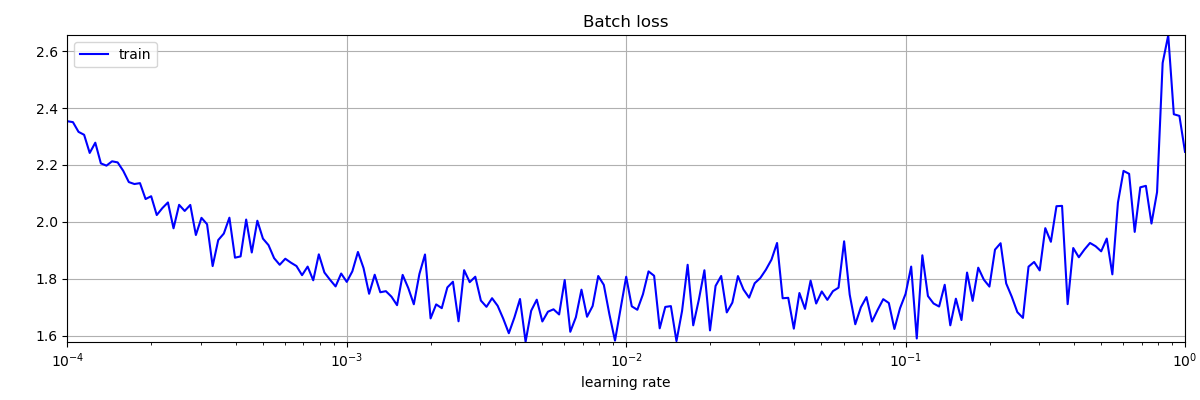

In [13]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

import torch.optim as optim

LossFunc      = nn.CrossEntropyLoss()
oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=1, betas=(0.9, 0.99), weight_decay=1e-2)
vLearningRate = np.logspace(-4, 0, 201)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

For Colab users:

<IPython.core.display.Javascript object>


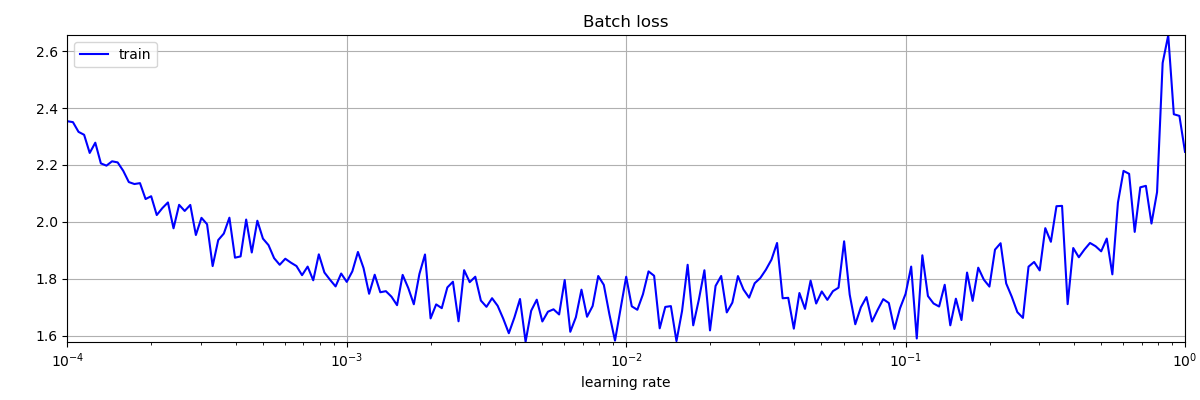

In [14]:
%matplotlib inline
oRecorder.fig

### Train the model:

<IPython.core.display.Javascript object>


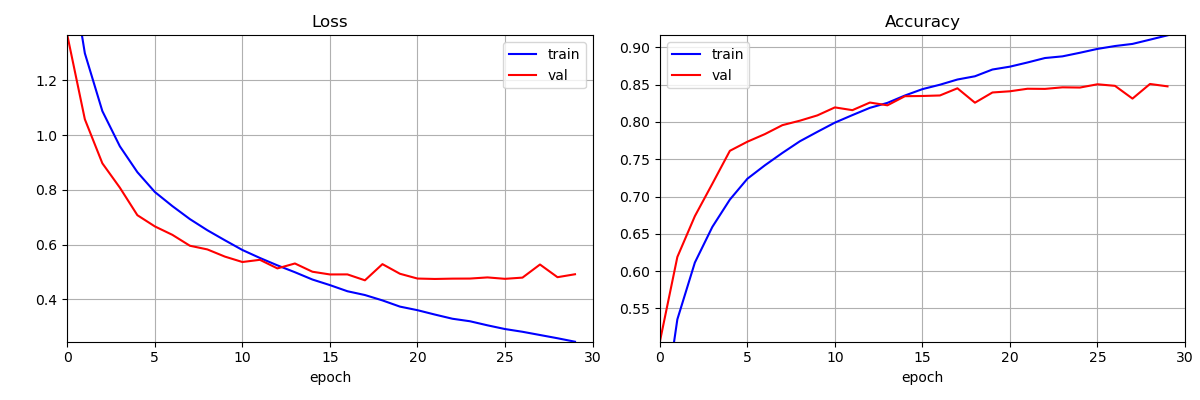

Epoch   0: | Train loss: 1.69364 | Val loss: 1.36481 | Train Accuracy: 0.3748 | Val Accuracy: 0.5054 | epoch time: 24.327 | <-- Checkpoint!
Epoch   1: | Train loss: 1.29923 | Val loss: 1.05789 | Train Accuracy: 0.5354 | Val Accuracy: 0.6190 | epoch time: 24.138 | <-- Checkpoint!
Epoch   2: | Train loss: 1.08784 | Val loss: 0.89693 | Train Accuracy: 0.6115 | Val Accuracy: 0.6737 | epoch time: 24.041 | <-- Checkpoint!
Epoch   3: | Train loss: 0.95907 | Val loss: 0.80787 | Train Accuracy: 0.6593 | Val Accuracy: 0.7172 | epoch time: 24.447 | <-- Checkpoint!
Epoch   4: | Train loss: 0.86458 | Val loss: 0.70726 | Train Accuracy: 0.6959 | Val Accuracy: 0.7613 | epoch time: 25.968 | <-- Checkpoint!
Epoch   5: | Train loss: 0.79200 | Val loss: 0.66620 | Train Accuracy: 0.7239 | Val Accuracy: 0.7735 | epoch time: 24.848 | <-- Checkpoint!
Epoch   6: | Train loss: 0.74046 | Val loss: 0.63540 | Train Accuracy: 0.7419 | Val Accuracy: 0.7837 | epoch time: 25.594 | <-- Checkpoint!
Epoch   7: | Train l

In [15]:
%matplotlib notebook

oModel   = GetModel().to(device)
oOptim   = optim.AdamW(oModel.parameters(), lr=4e-3, betas=(0.9, 0.99), weight_decay=1e-2)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, 30, oOptim)